/home/ezrahuang/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


module shapes:  [(3, 3, 5), (4, 4, 7)]
N_g     :  157
N_patts :  5040
N_h     :  400


/home/ezrahuang/Projects/rl-research/vectorhash/nd_scaffold.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pdf = torch.nn.functional.softmax(s)


g: tensor([0.1343, 0.0494, 0.0494, 0.0494, 0.0494, 0.0494, 0.0182, 0.0182, 0.0182,
        0.0182, 0.0494, 0.0182, 0.0182, 0.0182, 0.0182, 0.0494, 0.0182, 0.0182,
        0.0182, 0.0182, 0.0182, 0.0067, 0.0067, 0.0067, 0.0067, 0.0182, 0.0067,
        0.0067, 0.0067, 0.0067, 0.0494, 0.0182, 0.0182, 0.0182, 0.0182, 0.0182,
        0.0067, 0.0067, 0.0067, 0.0067, 0.0182, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0705, 0.0259, 0.0259, 0.0259, 0.0259, 0.0259, 0.0259, 0.0259, 0.0095,
        0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0259, 0.0095, 0.0095, 0.0095,
        0.0095, 0.0095, 0.0095, 0.0259, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095,
        0.0095, 0.0259, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095,
        0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0035, 0.0095, 0.0035, 0.0035,
        0.0035, 0.0035, 0.0035, 0.0035, 0.0095, 0.0035, 0.0035, 0.0035, 0.0035,
        0.0035, 0.0035, 0.0259, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095,
        0.0095, 0.0035, 0.0035, 0.003

Text(0, 0.5, 'similarity')

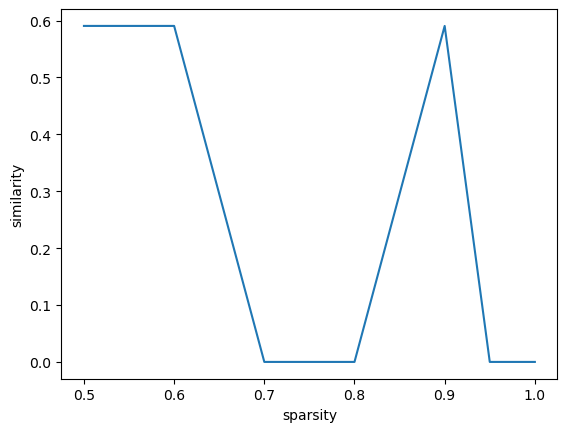

In [1]:
import numpy as np
import torch
from nd_scaffold import GridScaffold, SparseMatrixBySparsityInitializer
from graph_utils import graph_scaffold, print_imgs_side_by_side
import os


def test_mnist(num_imgs=1, prefix="", relu_theta=0.5, sparsity=0.1, N_h=400):
    import torchvision
    from torchvision import transforms

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
    )

    mnist = torchvision.datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )

    mnist_data = mnist.data.flatten(1).float().to("cuda")[:num_imgs]
    mnist_data = (mnist_data - mnist_data.mean()) / mnist_data.std()
    l = mnist_data.shape[0]

    shapes = [(3, 3, 5), (4, 4, 7)]
    velocities = torch.tile(torch.tensor([[0.8, 0.1, 0.1]]), (l, 1)).to("cuda")

    if False and os.path.exists("checkpoint.pt"):
        GS = GridScaffold.load("checkpoint.pt", device="cuda")
    else:
        GS = GridScaffold(
            shapes=shapes,
            N_h=N_h,
            input_size=784,
            device="cuda",
            sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
                sparsity=sparsity,
                device="cuda",
            ),
            relu_theta=relu_theta,
        )
        # GS.checkpoint("checkpoint.pt")

    # graph_scaffold(GS)

    # random_noise = torch.zeros_like(mnist_data).uniform_(-128, 128)
    noisy_mnist = mnist_data  # + random_noise
    # recalled_imgs = GS.recall(noisy_mnist)

    # for i in range(1):
    #     original_img = mnist_data[i].reshape(28, 28).cpu().numpy()
    #     noisy_img = noisy_mnist[i].reshape(28, 28).cpu().numpy()
    #     recalled_img = recalled_imgs[i].reshape(28, 28).cpu().numpy()
    #     print_imgs_side_by_side(
    #         original_img,
    #         noisy_img,
    #         recalled_img,
    #         out=f"mnist_unlearned_{i}.png",
    #         captions=["original", "noisy", "recalled"],
    #         title="Unlearned",
    #     )

    GS.learn_path(observations=mnist_data, velocities=velocities)
    recalled_imgs = GS.recall(noisy_mnist)

    for i in range(1):
        original_img = mnist_data[i].reshape(28, 28).cpu().numpy()
        noisy_img = noisy_mnist[i].reshape(28, 28).cpu().numpy()
        recalled_img = recalled_imgs[i].reshape(28, 28).cpu().numpy()
        print_imgs_side_by_side(
            original_img,
            noisy_img,
            recalled_img,
            out=f"{prefix}mnist_learned_{i}.png",
            captions=["original", "noisy", "recalled"],
            title="Learned",
        )

    similarity = torch.nn.functional.cosine_similarity(mnist_data, GS.recall(noisy_mnist))
    return similarity

sparsitys = [0.5,0.6,0.7,0.8,0.9,0.95,0.99,1]
similarities = np.zeros(len(sparsitys))
N = 10
for i, sparsity in enumerate(sparsitys):
    simliarity = test_mnist(N, prefix=f"sparsity_{sparsity}_", sparsity=sparsity).sum().item() / N 
    similarities[i] = simliarity

# plot sim against relu_theta
import matplotlib.pyplot as plt

print(sparsitys, similarities)
plt.plot(sparsitys, similarities)
plt.xlabel("sparsity")
plt.ylabel("similarity")

In [2]:

print(sparsitys, similarities)

[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1] [0.5906003 0.5906003 0.        0.        0.5906003 0.        0.
 0.       ]
